Plot GSEA analysis

In [1]:
# python modules
import sys
import copy
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
def select_best (gs_list, num):
    nes_gs = []
    for gs in gs_list:
        nes = gs['nes']
        nes_gs.append((abs(nes), gs))
    nes_gs = sorted(nes_gs, reverse=True)
    return [gs for _, gs in nes_gs[:num]]


In [5]:
### compute the Cohen's kappa of all gene-set pairs
def get_kappa_matrix (gs_list,
                      gene_list=None):
    # make union gene_list to be considered
    if gene_list == None:
        gene_list = set([])
        for gs in gs_list:
            gene_list |= set(gs['genes'].keys())
        gene_list = list(gene_list)

    # make binary vector for each gene-set
    idx_bvec = []
    for i in range(len(gs_list)):
        gs = gs_list[i]
        bvec = []
        for gene in gene_list:
            try:
                gs['genes'][gene]
                bvec.append(1)
            except:
                bvec.append(0)
        idx_bvec.append(bvec)

    # make kappa matrix
    kappa_matrix = np.zeros((len(gs_list), len(gs_list)))
    kappa_matrix[:] = np.nan
    for i in range(len(gs_list)):
        for j in range(i, len(gs_list)):
            bvec1, bvec2 = idx_bvec[i], idx_bvec[j]
            kappa = statis.get_kappa(bvec1, bvec2)
            kappa_matrix[i][j] = kappa
            kappa_matrix[j][i] = kappa

    return gene_list, kappa_matrix

In [6]:
# convert kappa matrix to distance matrix
def kappa_to_dist (kappa_matrix, scale=1.0):
    nrow, ncol = kappa_matrix.shape
    dist_matrix = np.zeros((nrow, ncol))
    for i in range(nrow):
        for j in range(ncol):
            if i == j:
                dist_matrix[i][j] = 0
                continue
            kappa = kappa_matrix[i][j]
            dist = scale*(1.0 - kappa)
            #dist_matrix[i][j] = np.exp(dist)
            dist_matrix[i][j] = dist
    return dist_matrix

In [7]:
# clean gene-set name
def clean_gsname(gsname):
    capital_words = ['B', 'STAT', 'H3K4ME2', 'H3K4ME3', 'H3K27ME3',
                     'IPS', 'NPC', 'HCP', 'HDAC', 'ICP', 'CD4', 'CD8',
                     'T', 'mRNA', 'RNA']
    word_to_symbol = {'MRNA':'mRNA',
                      'ALPHA':'$\\alpha$',
                      'BETA':'$\\beta$'}
    
    words = gsname.split('_')[1:]
    for k in range(len(words)):
        try:
            words[k] = word_to_symbol[words[k]]
        except:
            pass
        if words[k] not in capital_words:
            words[k] = words[k].lower()

    words[0] = words[0][0].upper() + words[0][1:]
    new_name = ' '.join(words)
    return new_name 


In [8]:
### load GSEA rank file
#rnk_fname1 = 'mCD8T_DFMO-WT.rnk'
#rnk_fname2 = 'mCD8T_ODCKO-WT.rnk'
rnk_path1 = '/Users/sangwoopark/Projects/condense-seq/ipython_notebooks/data/GSEA_mCD8T_DFMO_VS_WT/edb/'
rnk_path2 = '/Users/sangwoopark/Projects/condense-seq/ipython_notebooks/data/GSEA_mCD8T_ODCKO_VS_WT/edb/'
rnk_fname1 = 'mCD8T_DFMOvsWT_gname.rnk'
rnk_fname2 = 'mCD8T_ODCKOvsWT_gname.rnk'
gene_value1 = load_file.read_rank(rnk_path1 + rnk_fname1)
gene_value2 = load_file.read_rank(rnk_path2 + rnk_fname2)

In [9]:
### load GSEA data
#GSEA_path = '/Users/sangwoopark/jhu_rockfish/MouseEpigeneticData/GSEA_data/'
GSEA_dir = '/Users/sangwoopark/Projects/condense-seq/ipython_notebooks/data/'
#GSEA_path1 = path + "GSEA_DFMO_GOBP"
#GSEA_path2 = path + "GSEA_ODCKO_GOBP"
GSEA_path1 = GSEA_dir + "GSEA_mCD8T_DFMO_VS_WT"
GSEA_path2 = GSEA_dir + "GSEA_mCD8T_ODCKO_VS_WT"
pos_gs_list1, neg_gs_list1 = load_file.read_GSEA(GSEA_path1)
pos_gs_list2, neg_gs_list2 = load_file.read_GSEA(GSEA_path2)

In [10]:
### select gene-sets with the biggest |nes|
#num = 20
#gs_list1 = select_best(pos_gs_list1 + neg_gs_list1, num)
#gs_list2 = select_best(pos_gs_list2 + neg_gs_list2, num)
num = 10
gs_list1 = select_best(pos_gs_list1, num) + select_best(neg_gs_list1, num)
gs_list2 = select_best(pos_gs_list2, num) + select_best(neg_gs_list2, num)



In [11]:
### hierarchial clustering gene-sets based on the degree of sharing genes using Kappa-metric
gs_list = []
for gs in gs_list1 + gs_list2:
    if gs not in gs_list:
        gs_list.append(gs)
        
gene_list, kappa_matrix = get_kappa_matrix (gs_list)
dist_matrix = kappa_to_dist (kappa_matrix)
Z, idx_cID, cID_idxs = statis.Hierarchial_clustering (dist_matrix)

In [12]:
### color gene-set names based on the cluster groups
cID_color = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple'] *10
gsname_label, gsname_color = {}, {}
gsnames, gslabels = [], []
for gs, cID in zip(gs_list, idx_cID):
    gsname = gs['name']
    label = clean_gsname(gsname)
    color = cID_color[cID]
    gsname_label[gsname] = label
    gsname_color[gsname] = color
    gsnames.append(gsname)
    gslabels.append(label)

In [13]:
# set node color of dendrogram
node_children, node_dist, node_names = statis.decode_Z(Z, gsnames)
node_color = {}
for node in node_names:
    names = list(node_names[node])
    
    colors = set([])
    for name in names:
        color = gsname_color[name]
        colors.add(color)
    colors = list(colors)

    if len(colors) == 1:
        node_color[node] = colors[0]
    else:
        node_color[node] = 'blue'

# set leaf color of dendrogram
gslabel_color = {clean_gsname(gsname):gsname_color[gsname] for gsname in gsnames}

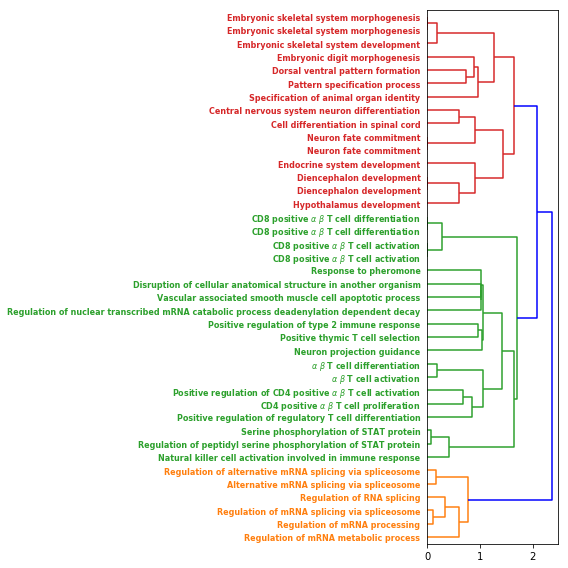

In [14]:
### plot dendrogram of clustering of the selected gene-sets
graphics.plot_dendrogram(Z,
                         gslabels,
                         node_color=node_color,
                         name_color=gslabel_color,
                         save_path='./data/',
                         save=True,
                         note='mCD8T_GSEA')


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


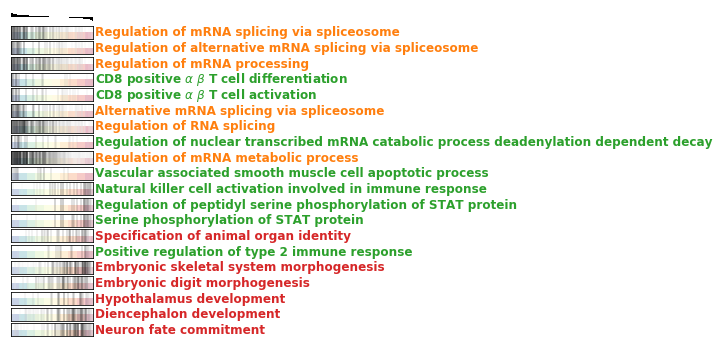

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc498982c50>,
      dtype=object)

In [15]:
### plot GSEA
# DFMO vs WT
graphics.plot_GSEA (gene_value1,
                    gs_list1,
                    gsname_label=gsname_label,
                    gsname_color=gsname_color,
                    save_path='./data/',
                    fig_width=2.5,
                    fig_height=6,
                    fontsize=12,
                    save=True,
                    note='DFMO-WT')


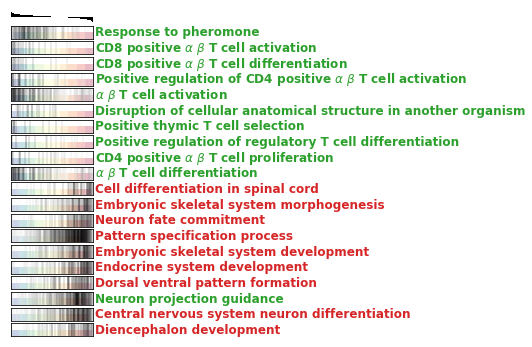

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4b2410c50>,
      dtype=object)

In [16]:
# KO vs WT
graphics.plot_GSEA (gene_value2,
                    gs_list2,
                    gsname_label=gsname_label,
                    gsname_color=gsname_color,
                    save_path='./data/',
                    fig_width=2.5,
                    fig_height=6,
                    fontsize=12,
                    save=True,
                    note='ODCKO-WT')